In [142]:
%pip install torchdiffeq

Note: you may need to restart the kernel to use updated packages.


In [143]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from functools import partial
from torch.autograd.functional import jacobian, hessian

from torchdiffeq import odeint as tor_odeint
from torchdiffeq import odeint_adjoint as tor_odeintadj
torch.version.__version__

'2.1.2'

Lagrangian for spring pendulum, in 2D, with $r$ spring length, $\theta$ angle from vertical: 

$\mathcal{L} = T - V = \frac{1}{2}\dot{r}^2 + \frac{1}{2} r^2\dot{\theta}^2 - gr(1-\cos(\theta)) - k(r -r_0)^2$

By applying Euler Lagrange equations get:

$\ddot r = r\dot{\theta}^2 + g(1-\cos(\theta)) - 2k(r-r_0)$

and 

$\ddot \theta = -\frac{1}{r}(g\sin(\theta) + 2\dot{r}\dot{\theta})$

can use these and `odeint` to solve analytically.



In [144]:
def lagrangian(x, g=10, k=10):
    q, qt = torch.split(x, 2)
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 

# If x is a tensor, E will return a tensor. If not, then a np array.

def E(x, g=10, k=10):
    try:
        q, qt = torch.split(x, 2)
        cos = torch.cos
    except: 
        q, qt = np.split(x, 2)
        cos = np.cos
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-cos(q[1])) + k*(q[0] - 1)**2
    return T + V 


In [145]:


def get_qdotdot(q, qt, g=10, k=10):
    '''
    q is array of generalised coords, [r, theta]
    qt is array of generalised coords, [rdt, thetadt]

    returns q double dot.
    '''
    qdtt = np.zeros_like(q)

    qdtt[:, 0] = q[:, 0]*qt[:, 1]**2 - g*(1-np.cos(q[:, 1])) - 2*k*(q[:, 0]-1) 
    qdtt[:, 1] = (-g*np.sin(q[:, 1]) -2*qt[:, 0]*qt[:, 1])/q[:, 0]

    return qdtt  


# Returns q_dot and q_dotdot 

def analytically_differentiated_state(x, t):
    d = np.zeros_like(x)
    d[:, :2] = x[:, 2:]
    d[:, 2:] = get_qdotdot(x[:, :2], x[:, 2:])

    # print(x, d)
    return d


# This takes only 4 numbers: the starting position and velocity. 
# f_anal function returns q_dot and q_dotdot for 1 dimensional inputs.

# Returns:
# An array containing the value of y for each desired time in t, with the initial value y0 in the first row.


def ode_solve_analytic(q0, qt0, t,):

    x0 = np.append(q0, qt0)

    def f_analytic(x, t):
        d = np.zeros_like(x)
        d[:2] = x[2:]
        d[2:] = np.squeeze(get_qdotdot(np.expand_dims(x[:2], axis=0), np.expand_dims(x[2:], axis=0)))
        # print(x, d)
        return d
    
    return odeint(f_analytic, x0, t, rtol=1e-10, atol=1e-10)
    
def polar_to_cartesian(ql):
    '''
    Polar coords to xy
    '''
    try: 
        xy = np.zeros_like(ql)
        sin = np.sin
        cos = np.cos
        print("np")
    except: 
        xy = torch.zeros_like(ql)
        sin = torch.sin
        cos = torch.cos

    xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
    xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
    return xy  


In [146]:
t = np.arange(0, 5, 0.005)

# We initialized two posiiton vectors (and their corrosponding velocities to zero) 
# to see how a small variation effects the trajectory.

q0 = np.array([1.1, 0.5])
q0p = np.array([1.1 + 1e-5, 0.5])
qt0 = np.array([0.0, 0.0])

# %timeit path = ode_solve_analytic(q0, qt0, t)
path = ode_solve_analytic(q0, qt0, t)
ppath = ode_solve_analytic(q0p, qt0, t)
xy = polar_to_cartesian(path)
pxy = polar_to_cartesian(ppath)

np
np


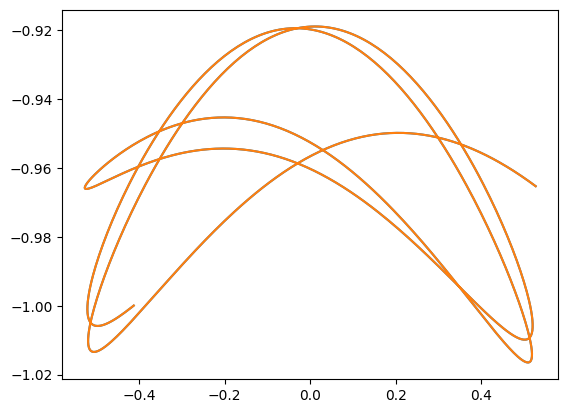

In [147]:
plt.plot(xy[:, 0], xy[:, 1])
plt.plot(pxy[:, 0], pxy[:, 1])

We can also solve using pytorch to autodiff the lagrangian, an use the following version of the EL equations (after Cranmer et al.), with $q=(r, \theta)$:

$\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q]$





In [148]:
# Gets the q_dot, q_dotdot by differentiating a function "lagrangian" wrt E-L equations.

def get_xt(lagrangian, t, x):
    n = x.shape[0]//2
    xv = torch.autograd.Variable(x, requires_grad=True)
    tq, tqt = torch.split(xv, 2, dim=0)

    A = torch.inverse(hessian(lagrangian, xv, create_graph=True)[n:, n:])
    B = jacobian(lagrangian, xv, create_graph=True)[:n]
    C = hessian(lagrangian, xv, create_graph=True)[n:, :n]

    tqtt = A @ (B - C @ tqt)

    xt = torch.cat([tqt, torch.squeeze(tqtt)])

    return xt


# This takes the starting coordinates and f fills the first argument of get_xt with "lagrangian",
# so that this can directly go into tor_odeint function, which is similar to the previous one.
def torch_solve_ode(x0, t, lagrangian):
    f = partial(get_xt, lagrangian)
    return tor_odeint(f, x0, t)

In [149]:
# Solving the system using the analytically provided Lagrangian!

tx0 = torch.cat([torch.tensor(q0), torch.tensor(qt0)])
tt = torch.tensor(t)
tpath = torch_solve_ode(tx0, tt, lagrangian)

# %timeit tpath = torch_solve_ode(tx0, tt, lagrangian)
txy = polar_to_cartesian(tpath)

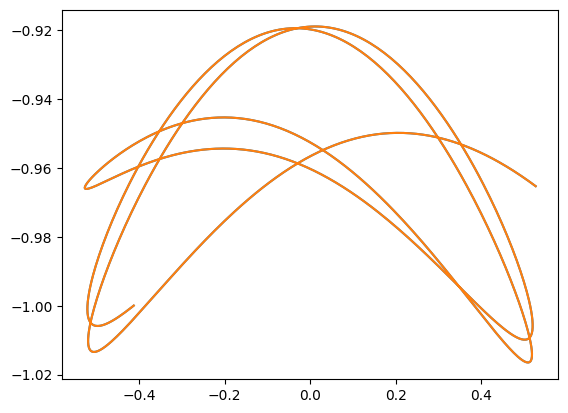

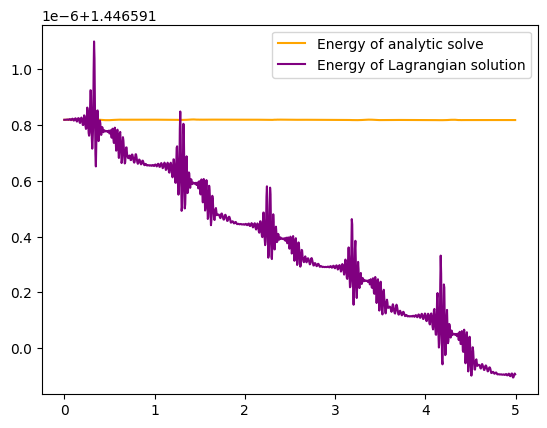

In [150]:
plt.plot(xy[:, 0], xy[:, 1])
plt.plot(txy.detach()[:, 0], txy.detach()[:, 1])
En = [E(x) for x in path]
Ent = [E(x) for x in tpath.detach()]
plt.show()
plt.plot(t, En, color='orange', label='Energy of analytic solve')

plt.plot(t, Ent, color='purple', label= 'Energy of Lagrangian solution')

plt.legend()

plt.show()

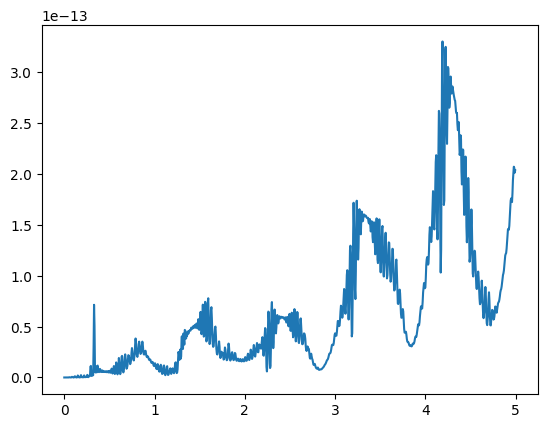

In [151]:
# Mean square difference between analytical straight solution and analytical Lagrangian solution.

plt.plot(t, np.sum((tpath.detach().numpy() - path)**2, axis=1))

In [152]:
def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [153]:
def random_initialize(start=0, end=10, dim=2, distribution='uniform'):
    if distribution == 'uniform':
        positions = np.random.uniform(start, end, size=(dim,))
        return positions
    if distribution == 'gaussian':
        mean = (start + end) / 2  # Mean of the Gaussian distribution
        std_dev = (end - start) / (2 * np.sqrt(3))  # Standard deviation of the Gaussian distribution
        positions = np.random.normal(mean, std_dev, size=(dim,))
        # Clip values to ensure they fall within the specified range
        positions = np.clip(positions, start, end)
        return positions
    else:
        raise ValueError("Invalid distribution type. Please choose 'uniform' or 'gaussian'.")

In [178]:

#starting_positions = random_initialize(0,10)
starting_positions = np.array([1.1, 0.5])
starting_velocities = np.array([0.0, 0.0])
#starting_velocities = random_initialize(0, 2, 2, 'gaussian')

t_total = torch.tensor(np.linspace(0, 20, 1500)).float()


#Split the train and test in a ratio of 0.8.
#train_size = int(0.8 * len(t_total)) 

#train_size = int(0.5 * len(t_total))

test_size = len(t_total) - train_size 

#indices = torch.randperm(len(t_total))

#train_indices = indices[:train_size]
#test_indices = indices[train_size:]

#print('test_indices:',test_indices)

#t_train = t_total[train_indices]
#t_test = t_total[test_indices]


#Tried to split WITHOUT permutating. Somehow, this gives errors.
#t_train = t_total[:train_size]
#t_test = t_total[train_size:]

t_train = torch.tensor(np.linspace(0, 10, 1500)).float()
t_test = torch.tensor(np.linspace(10, 20, 1500)).float()

print("Size of t_train:", len(t_train))
print("Size of t_test:", len(t_test))

tstep = t_train[1].item() 

#q_train is still only considering only the same system!

#q_total = torch.tensor(ode_solve_analytic(starting_positions, starting_velocities, t_total)).float()

print(q_total)
print(q_total.max())
print(q_total.min())
print(t_total)

#q_train = q_total[train_indices]
#q_train = q_total[:train_size]
q_train = torch.tensor(ode_solve_analytic(starting_positions, starting_velocities, t_train)).float()

qdot_train = torch.tensor(analytically_differentiated_state(q_train, t_train)).float()
rk4_train = torch.tensor(rk4_step(analytically_differentiated_state, q_train, t_train, tstep)).float()

print(qdot_train)
print(qdot_train.max())

#q_test = q_total[train_size:]
#q_test = q_total[test_indices]
q_test = torch.tensor(ode_solve_analytic(starting_positions, starting_velocities, t_test)).float()

qdot_test = torch.tensor(analytically_differentiated_state(q_test, t_test)).float()


rk4_test = torch.tensor(rk4_step(analytically_differentiated_state, q_test, t_test, tstep)).float()


Size of t_train: 1500
Size of t_test: 1500
tensor([[ 1.1000,  0.5000,  0.0000,  0.0000],
        [ 1.0997,  0.4996, -0.0430, -0.0582],
        [ 1.0989,  0.4984, -0.0856, -0.1164],
        ...,
        [ 1.0825, -0.4176,  0.4228, -0.7824],
        [ 1.0880, -0.4277,  0.3965, -0.7244],
        [ 1.0931, -0.4369,  0.3671, -0.6666]])
tensor(1.8083)
tensor(-1.8073)
tensor([0.0000e+00, 1.3342e-02, 2.6684e-02,  ..., 1.9973e+01, 1.9987e+01,
        2.0000e+01])
tensor([[ 0.0000,  0.0000, -3.2242, -4.3584],
        [-0.0215, -0.0291, -3.2213, -4.3591],
        [-0.0430, -0.0582, -3.2129, -4.3610],
        ...,
        [-0.4281, -1.6524,  3.5576, -3.0637],
        [-0.4040, -1.6722,  3.6836, -2.8887],
        [-0.3790, -1.6909,  3.8023, -2.7047]])
tensor(4.8456)


/tmp/ipykernel_34/2344460955.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rk4_train = torch.tensor(rk4_step(analytically_differentiated_state, q_train, t_train, tstep)).float()
/tmp/ipykernel_34/2344460955.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rk4_test = torch.tensor(rk4_step(analytically_differentiated_state, q_test, t_test, tstep)).float()


In [179]:
class LNN(nn.Module):
    def __init__(self):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def lagrangian(self, x): 
        x = F.softmax(self.fc1(x))
        x = F.softmax(self.fc2(x))
        x = self.fc3(x)
        return x 

    def forward(self, x):

        n = x.shape[1]//2
        xv = torch.autograd.Variable(x, requires_grad=True)
        xv_tup = tuple([xi for xi in x]) 

        #print("xv_tup:",xv_tup)
        tqt = xv[:, n:]

        jacpar = partial(jacobian,  self.lagrangian, create_graph=True)
        hesspar = partial(hessian,  self.lagrangian, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))

        #print("A:", A)
        
        multi = lambda Ai, Bi, tqti, n:  torch.pinverse(Ai[n:, n:]) @ (Bi[:n, 0] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))
        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        xt.retain_grad()
        return xt

    def t_forward(self, t, x):
        return self.forward(x)

def loss(pred, targ):
    return torch.mean((pred - targ)**2)

def nn_solve_ode(model, x0, t):

    x0 = x0.detach().numpy()
    def f(x, t):
        x_tor = torch.tensor(np.expand_dims(x, 0), requires_grad=True).float()
        return np.squeeze(model(x_tor).detach().numpy(), axis=0)
    return odeint(f, x0, t)  

In [180]:
eps = 100
N = 1500 
batch_size = 100 

model = LNN()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_list = []
for e in range(eps):
    running_loss = 0.
    for i in range(1, N // batch_size):
        optimizer.zero_grad()
        xi = qdot_train[(i-1)*batch_size:i*batch_size]
        xt_pred = model(xi)

        loss_val = loss(xt_pred, qdot_train[i])
        loss_val.backward()

        optimizer.step()

        running_loss += loss_val.item()


    print('[%d, %5d] loss: %.10f' %
          (e + 1, i + 1, running_loss/N))
    
    loss_list.append(running_loss/N)
    running_loss = 0.0
        
        

/tmp/ipykernel_34/1603652870.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc1(x))
/tmp/ipykernel_34/1603652870.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


[1,    15] loss: 3.2188158747
[2,    15] loss: 0.6364951725
[3,    15] loss: 104.2106804047
[4,    15] loss: 3101.3718385601
[5,    15] loss: 1.1794725545
[6,    15] loss: 20.4448928680
[7,    15] loss: 52.6237474683
[8,    15] loss: 13.3119598109
[9,    15] loss: 48.5738638458
[10,    15] loss: 6.5023226178
[11,    15] loss: 5.9247585169
[12,    15] loss: 5.8089230550
[13,    15] loss: 5.7771968969
[14,    15] loss: 5.7700568759
[15,    15] loss: 5.7689161835
[16,    15] loss: 5.7695964419
[17,    15] loss: 5.7701304131
[18,    15] loss: 5.7698119710
[19,    15] loss: 5.7695029475
[20,    15] loss: 5.7693849042
[21,    15] loss: 5.7680863609
[22,    15] loss: 5.7671012573


KeyboardInterrupt: 

In [ ]:
torch.save(model_april, '/kaggle/working/model_april.pt')

In [185]:
#model = torch.load('/kaggle/input/first_model_lnn/pytorch/first/1/model.pt')
#model.eval()

LNN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [186]:

nn_test = nn_solve_ode(model, q_train[0], t_train)


/tmp/ipykernel_34/1603652870.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc1(x))
/tmp/ipykernel_34/1603652870.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5706735389440D-02   r2 =  0.2594858385957D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5706735389440D-02   r2 =  0.2594858385957D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5706735389440D-02   r2 =  0.2594858385957D-18


/tmp/ipykernel_34/1603652870.py:53: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(f, x0, t)


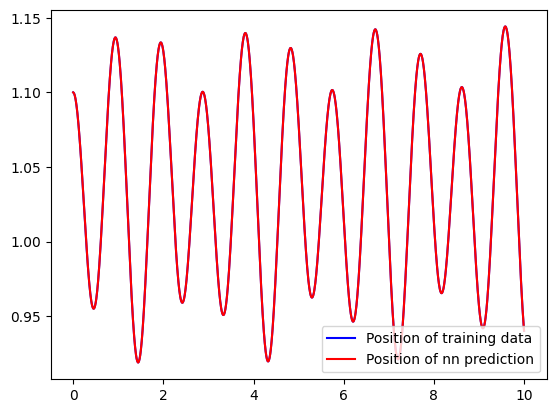

In [187]:
plt.plot(t_train, q_train[:, 0], color='blue', label='Position of training data')
plt.plot(t_train, nn_test[:, 0], color='red', label='Position of nn prediction')
plt.legend()
plt.show()
#plt.plot(np.arange(len(loss_list)), loss_list)
#plt.yscale('log')


In [188]:
for i in range(10):
    print((nn_test[i], q_train[i]))

(array([1.10000002, 0.5       , 0.        , 0.        ]), tensor([1.1000, 0.5000, 0.0000, 0.0000]))
(array([ 1.0998183 ,  0.49975623, -0.09797156, -0.12725193]), tensor([ 1.0999,  0.4999, -0.0215, -0.0291]))
(array([ 1.09971319,  0.49961203, -0.04296734, -0.05816246]), tensor([ 1.0997,  0.4996, -0.0430, -0.0582]))
(array([ 1.09935515,  0.49912696, -0.06435667, -0.08726521]), tensor([ 1.0994,  0.4991, -0.0644, -0.0873]))
(array([ 1.09885478,  0.49844766, -0.0856329 , -0.11639364]), tensor([ 1.0989,  0.4984, -0.0856, -0.1164]))
(array([ 1.09821296,  0.49757393, -0.10675848, -0.14555608]), tensor([ 1.0982,  0.4976, -0.1068, -0.1456]))
(array([ 1.0974308 ,  0.49650552, -0.12769598, -0.17476062]), tensor([ 1.0974,  0.4965, -0.1277, -0.1748]))
(array([ 1.09650971,  0.49524213, -0.14840819, -0.20401517]), tensor([ 1.0965,  0.4952, -0.1484, -0.2040]))
(array([ 1.09545129,  0.49378338, -0.16885803, -0.23332724]), tensor([ 1.0955,  0.4938, -0.1689, -0.2333]))
(array([ 1.09425743,  0.49212888, -0

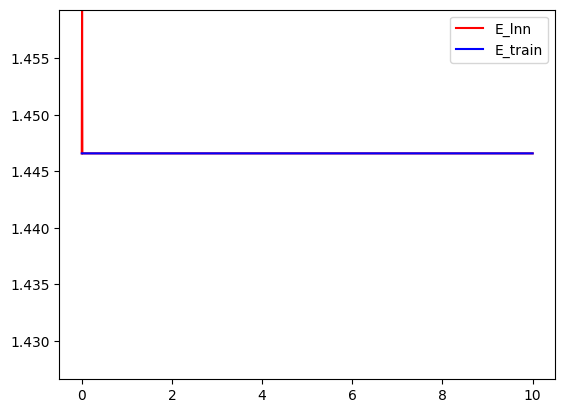

In [189]:
E_train = [E(x) for x in q_train]
E_lnn = [E(x) for x in nn_test]

plt.plot(t_train, E_lnn, color='red', label='E_lnn')
plt.plot(t_train, E_train, color='blue', label='E_train')


plt.ylim(min(min(E_train), min(E_lnn))-0.02, max(max(E_train), max(E_lnn)))
plt.legend()

plt.show()